# Clustering The World on COVID-19 Cases

This project attempts to cluster 191 countries according to the pattern of COVID-19 cases in the past 28 days.

*Note - The graphs and results can be different each day, because the data is updated every day.*

Example - Clusters produced on 21st November 2020
![Clusters produced on 21st November 2020](countries-20201121.png)

## 1. Data Preparation

### Import Libraries

In [1]:
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

import plotly.express as px
import plotly.io as pio

from datetime import date, datetime, timedelta

from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler

width = 1000
pio.renderers.default = "plotly_mimetype+notebook_connected"

Set number of days for the study.

In [2]:
ndays = 28
dateformat = '%Y-%m-%d'

### Load Data

In [3]:
dataset_url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv'
df = pd.read_csv(dataset_url)
df

,Date,Country,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,0,0,0
1,2020-01-23,Afghanistan,0,0,0
2,2020-01-24,Afghanistan,0,0,0
3,2020-01-25,Afghanistan,0,0,0
4,2020-01-26,Afghanistan,0,0,0
...,...,...,...,...,...
58059,2020-11-16,Zimbabwe,8897,8116,257
58060,2020-11-17,Zimbabwe,8945,8164,260
58061,2020-11-18,Zimbabwe,8981,8184,261
58062,2020-11-19,Zimbabwe,9046,8195,265


### Data Wrangling

In [4]:
df = df.assign(Cases = df['Confirmed'].diff())
df.dropna(inplace = True)
df

,Date,Country,Confirmed,Recovered,Deaths,Cases
1,2020-01-23,Afghanistan,0,0,0,0.0
2,2020-01-24,Afghanistan,0,0,0,0.0
3,2020-01-25,Afghanistan,0,0,0,0.0
4,2020-01-26,Afghanistan,0,0,0,0.0
5,2020-01-27,Afghanistan,0,0,0,0.0
...,...,...,...,...,...,...
58059,2020-11-16,Zimbabwe,8897,8116,257,68.0
58060,2020-11-17,Zimbabwe,8945,8164,260,48.0
58061,2020-11-18,Zimbabwe,8981,8184,261,36.0
58062,2020-11-19,Zimbabwe,9046,8195,265,65.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58063 entries, 1 to 58063
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       58063 non-null  object 
 1   Country    58063 non-null  object 
 2   Confirmed  58063 non-null  int64  
 3   Recovered  58063 non-null  int64  
 4   Deaths     58063 non-null  int64  
 5   Cases      58063 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 3.1+ MB


In [6]:
df['Cases'] = df['Cases'].astype(int)
df

,Date,Country,Confirmed,Recovered,Deaths,Cases
1,2020-01-23,Afghanistan,0,0,0,0
2,2020-01-24,Afghanistan,0,0,0,0
3,2020-01-25,Afghanistan,0,0,0,0
4,2020-01-26,Afghanistan,0,0,0,0
5,2020-01-27,Afghanistan,0,0,0,0
...,...,...,...,...,...,...
58059,2020-11-16,Zimbabwe,8897,8116,257,68
58060,2020-11-17,Zimbabwe,8945,8164,260,48
58061,2020-11-18,Zimbabwe,8981,8184,261,36
58062,2020-11-19,Zimbabwe,9046,8195,265,65


### Calculate Dates

In [7]:
df['Date'] = pd.to_datetime(df['Date'], format = dateformat)
df.dtypes

Date         datetime64[ns]
Country              object
Confirmed             int64
Recovered             int64
Deaths                int64
Cases                 int32
dtype: object

In [8]:
df.drop(['Confirmed', 'Recovered', 'Deaths'], axis = 1, inplace = True)
df

,Date,Country,Cases
1,2020-01-23,Afghanistan,0
2,2020-01-24,Afghanistan,0
3,2020-01-25,Afghanistan,0
4,2020-01-26,Afghanistan,0
5,2020-01-27,Afghanistan,0
...,...,...,...
58059,2020-11-16,Zimbabwe,68
58060,2020-11-17,Zimbabwe,48
58061,2020-11-18,Zimbabwe,36
58062,2020-11-19,Zimbabwe,65


In [9]:
end = df['Date'].max()
end

Timestamp('2020-11-20 00:00:00')

In [10]:
start = end - timedelta(days = (ndays - 1))
start

Timestamp('2020-10-24 00:00:00')

### Create New Table

In [11]:
df_period = df[df['Date'] >= start]
df_period

,Date,Country,Cases
276,2020-10-24,Afghanistan,81
277,2020-10-25,Afghanistan,65
278,2020-10-26,Afghanistan,104
279,2020-10-27,Afghanistan,95
280,2020-10-28,Afghanistan,113
...,...,...,...
58059,2020-11-16,Zimbabwe,68
58060,2020-11-17,Zimbabwe,48
58061,2020-11-18,Zimbabwe,36
58062,2020-11-19,Zimbabwe,65


In [12]:
countries = df_period['Country'].unique()
countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

In [13]:
df_grouped = df_period.groupby('Country')
df_grouped

In [14]:
sums = df_grouped['Cases'].sum()
sums

Country
Afghanistan            3756
Albania               12903
Algeria               17125
Andorra                2104
Angola                 5438
                      ...  
West Bank and Gaza    19189
Western Sahara            0
Yemen                    30
Zambia                 1278
Zimbabwe                863
Name: Cases, Length: 191, dtype: int32

In [15]:
means = df_grouped['Cases'].mean()
means

Country
Afghanistan           134.142857
Albania               460.821429
Algeria               611.607143
Andorra                75.142857
Angola                194.214286
                         ...    
West Bank and Gaza    685.321429
Western Sahara          0.000000
Yemen                   1.071429
Zambia                 45.642857
Zimbabwe               30.821429
Name: Cases, Length: 191, dtype: float64

In [16]:
stds = df_grouped['Cases'].std()
stds

Country
Afghanistan            73.900691
Albania               163.103933
Algeria               285.290280
Andorra                61.169900
Angola                 74.240030
                         ...    
West Bank and Gaza    260.002714
Western Sahara          0.000000
Yemen                   1.631372
Zambia                 27.761170
Zimbabwe               20.846980
Name: Cases, Length: 191, dtype: float64

In [17]:
maxes = df_grouped['Cases'].max()
maxes

Country
Afghanistan            377
Albania                836
Algeria               1103
Andorra                287
Angola                 355
                      ... 
West Bank and Gaza    1472
Western Sahara           0
Yemen                    6
Zambia                 118
Zimbabwe                74
Name: Cases, Length: 191, dtype: int32

In [18]:
mins = df_grouped['Cases'].min()
mins

Country
Afghanistan            40
Albania               241
Algeria               250
Andorra                 0
Angola                 77
                     ... 
West Bank and Gaza    410
Western Sahara          0
Yemen                   0
Zambia                  0
Zimbabwe                5
Name: Cases, Length: 191, dtype: int32

In [19]:
medians = df_grouped['Cases'].median()
medians

Country
Afghanistan           117.0
Albania               455.0
Algeria               636.5
Andorra                65.5
Angola                196.0
                      ...  
West Bank and Gaza    628.0
Western Sahara          0.0
Yemen                   0.0
Zambia                 41.0
Zimbabwe               27.0
Name: Cases, Length: 191, dtype: float64

In [20]:
df_countries = pd.DataFrame(
    {
        'Country': countries,
        'Sum': sums,
        'Mean': means,
        'Std': stds,
        'Max': maxes,
        'Min': mins,
        'Median': medians
    }
)

df_countries

,Country,Sum,Mean,Std,Max,Min,Median
Country,,,,,,,
Afghanistan,Afghanistan,3756,134.142857,73.900691,377,40,117.0
Albania,Albania,12903,460.821429,163.103933,836,241,455.0
Algeria,Algeria,17125,611.607143,285.290280,1103,250,636.5
Andorra,Andorra,2104,75.142857,61.169900,287,0,65.5
Angola,Angola,5438,194.214286,74.240030,355,77,196.0
...,...,...,...,...,...,...,...
West Bank and Gaza,West Bank and Gaza,19189,685.321429,260.002714,1472,410,628.0
Western Sahara,Western Sahara,0,0.000000,0.000000,0,0,0.0
Yemen,Yemen,30,1.071429,1.631372,6,0,0.0


In [21]:
df_countries.reset_index(drop = True, inplace = True)
df_countries

,Country,Sum,Mean,Std,Max,Min,Median
0,Afghanistan,3756,134.142857,73.900691,377,40,117.0
1,Albania,12903,460.821429,163.103933,836,241,455.0
2,Algeria,17125,611.607143,285.290280,1103,250,636.5
3,Andorra,2104,75.142857,61.169900,287,0,65.5
4,Angola,5438,194.214286,74.240030,355,77,196.0
...,...,...,...,...,...,...,...
186,West Bank and Gaza,19189,685.321429,260.002714,1472,410,628.0
187,Western Sahara,0,0.000000,0.000000,0,0,0.0
188,Yemen,30,1.071429,1.631372,6,0,0.0
189,Zambia,1278,45.642857,27.761170,118,0,41.0


### Explore Data

In [22]:
df_countries.isnull().sum()

Country    0
Sum        0
Mean       0
Std        0
Max        0
Min        0
Median     0
dtype: int64

In [23]:
df_countries[df_countries['Country'] == 'US']

,Country,Sum,Mean,Std,Max,Min,Median
176,US,3429046,122465.928571,39295.049374,195542,61760,124393.0


In [24]:
df_countries[df_countries['Country'] == 'India']

,Country,Sum,Mean,Std,Max,Min,Median
79,India,1235915,44139.821429,5500.864188,50356,29163,45625.0


In [25]:
df_countries[df_countries['Country'] == 'Malaysia']

,Country,Sum,Mean,Std,Max,Min,Median
107,Malaysia,28124,1004.428571,243.560842,1755,649,965.0


## 2. Data Visualization

In [26]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Sum')
fig.update_layout(title_text = f'COVID-19 - Total Number of Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [27]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Mean')
fig.update_layout(title_text = f'COVID-19 - Daily Average Number of Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [28]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Std', width = width)
fig.update_layout(title_text = f'COVID-19 - Standard Deviation of Number of Daily Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [29]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Max')
fig.update_layout(title_text = f'COVID-19 - Highest Number of Daily Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [30]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Min')
fig.update_layout(title_text = f'COVID-19 - Lowest Number of Daily Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [31]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Median')
fig.update_layout(title_text = f'COVID-19 - Median Number of Daily Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [32]:
df_countries.corr()

,Sum,Mean,Std,Max,Min,Median
Sum,1.000000,1.000000,0.893449,0.955627,0.926925,0.999321
Mean,1.000000,1.000000,0.893449,0.955627,0.926925,0.999321
Std,0.893449,0.893449,1.000000,0.981891,0.672317,0.881583
Max,0.955627,0.955627,0.981891,1.000000,0.788096,0.946800
Min,0.926925,0.926925,0.672317,0.788096,1.000000,0.934624
Median,0.999321,0.999321,0.881583,0.946800,0.934624,1.000000


## Model Training

In [33]:
# Features = df_countries.drop(['Country', 'Sum'], axis = 1).columns # Use almost all columns for training
Features = ['Median', 'Std'] # Use selected columns for training
Features

['Median', 'Std']

In [34]:
scaled_features = StandardScaler().fit_transform(df_countries[Features])

In [35]:
start = 2
end = 11

sse = []

kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}

for k in range(start, end):
    print(f'Trying {k} clusters...')
    
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    print(f'SSE: {kmeans.inertia_}')
    
    print()

Trying 2 clusters...
SSE: 157.27490726702993

Trying 3 clusters...
SSE: 70.35292934598714

Trying 4 clusters...
SSE: 39.10641359680083

Trying 5 clusters...
SSE: 20.193576830561597

Trying 6 clusters...
SSE: 18.125149437404286

Trying 7 clusters...
SSE: 17.46668325713631

Trying 8 clusters...
SSE: 17.25709331505623

Trying 9 clusters...
SSE: 15.528887014709792

Trying 10 clusters...
SSE: 15.503894514094542



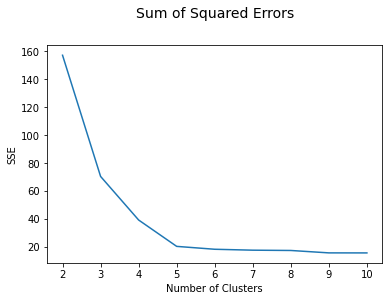

In [36]:
plt.plot(range(start, end), sse)
plt.xticks(range(start, end))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('Sum of Squared Errors', y = 1.1, fontsize = 14)
plt.show()

In [37]:
kl = KneeLocator(
   range(start, end), sse, curve="convex", direction="decreasing"
)

print(f'The optimal number of clusters: {kl.elbow}')

The optimal number of clusters: 5


In [38]:
kclusters = kl.elbow

kmeans = KMeans(n_clusters = kclusters, **kmeans_kwargs)
kmeans.fit(scaled_features)

labels = kmeans.labels_ + 1
labels

array([1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 5, 1, 3, 1, 1, 1, 5, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 5, 3, 1, 3, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       4, 1, 3, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Explore Clusters

In [39]:
if 'Cluster' in df_countries.columns:
    df_countries.drop('Cluster', axis = 1, inplace = True)
    
df_countries.insert(0, 'Cluster', labels)
df_countries

,Cluster,Country,Sum,Mean,Std,Max,Min,Median
0,1,Afghanistan,3756,134.142857,73.900691,377,40,117.0
1,1,Albania,12903,460.821429,163.103933,836,241,455.0
2,1,Algeria,17125,611.607143,285.290280,1103,250,636.5
3,1,Andorra,2104,75.142857,61.169900,287,0,65.5
4,1,Angola,5438,194.214286,74.240030,355,77,196.0
...,...,...,...,...,...,...,...,...
186,1,West Bank and Gaza,19189,685.321429,260.002714,1472,410,628.0
187,1,Western Sahara,0,0.000000,0.000000,0,0,0.0
188,1,Yemen,30,1.071429,1.631372,6,0,0.0
189,1,Zambia,1278,45.642857,27.761170,118,0,41.0


In [40]:
df_countries

,Cluster,Country,Sum,Mean,Std,Max,Min,Median
0,1,Afghanistan,3756,134.142857,73.900691,377,40,117.0
1,1,Albania,12903,460.821429,163.103933,836,241,455.0
2,1,Algeria,17125,611.607143,285.290280,1103,250,636.5
3,1,Andorra,2104,75.142857,61.169900,287,0,65.5
4,1,Angola,5438,194.214286,74.240030,355,77,196.0
...,...,...,...,...,...,...,...,...
186,1,West Bank and Gaza,19189,685.321429,260.002714,1472,410,628.0
187,1,Western Sahara,0,0.000000,0.000000,0,0,0.0
188,1,Yemen,30,1.071429,1.631372,6,0,0.0
189,1,Zambia,1278,45.642857,27.761170,118,0,41.0


### Visualize Clusters

In [41]:
df_plot = pd.DataFrame(df_countries['Cluster'].value_counts(sort = False))
df_plot.index.name = 'Cluster'
df_plot.columns = ['Count']
df_plot

,Count
Cluster,
1,163
2,2
3,18
4,1
5,7


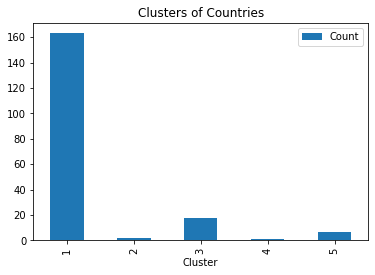

In [42]:
df_plot.plot.bar(title = 'Clusters of Countries')

Learn the characteristics of each cluster.

In [43]:
df_clusters = df_countries.groupby('Cluster')
df_clusters

In [44]:
df_clusters['Sum'].mean()

Cluster
1    1.266211e+04
2    7.931410e+05
3    1.808002e+05
4    3.429046e+06
5    7.208946e+05
Name: Sum, dtype: float64

In [45]:
df_clusters['Mean'].mean()

Cluster
1       452.218230
2     28326.464286
3      6457.148810
4    122465.928571
5     25746.234694
Name: Mean, dtype: float64

In [46]:
df_clusters['Std'].mean()

Cluster
1      164.095542
2    23102.242475
3     2503.101345
4    39295.049374
5     5825.653515
Name: Std, dtype: float64

In [47]:
df_clusters['Max'].mean()

Cluster
1       804.871166
2     90216.500000
3     11893.611111
4    195542.000000
5     36692.000000
Name: Max, dtype: float64

In [48]:
df_clusters['Min'].mean()

Cluster
1      184.110429
2       12.500000
3     2615.222222
4    61760.000000
5    13496.714286
Name: Min, dtype: float64

In [49]:
df_clusters['Median'].mean()

Cluster
1       447.815951
2     26760.000000
3      6234.805556
4    124393.000000
5     26234.000000
Name: Median, dtype: float64

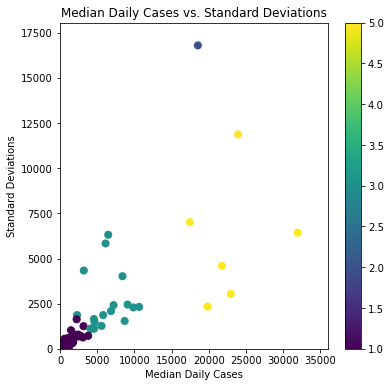

In [50]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)

scatter = ax.scatter(df_countries['Median'], df_countries['Std'], c = df_countries['Cluster'], s = 50)

ax.set_title('Median Daily Cases vs. Standard Deviations')
ax.set_xlabel('Median Daily Cases')
ax.set_ylabel('Standard Deviations')
ax.set_xlim(0, df_countries['Median'].quantile(0.99))
ax.set_ylim(0, df_countries['Std'].quantile(0.99))

plt.colorbar(scatter)

### List Clusters

In [51]:
for i in range(1, kclusters + 1):
    print(df_clusters.get_group(i))

     Cluster             Country    Sum        Mean         Std   Max  Min  \
0          1         Afghanistan   3756  134.142857   73.900691   377   40   
1          1             Albania  12903  460.821429  163.103933   836  241   
2          1             Algeria  17125  611.607143  285.290280  1103  250   
3          1             Andorra   2104   75.142857   61.169900   287    0   
4          1              Angola   5438  194.214286   74.240030   355   77   
..       ...                 ...    ...         ...         ...   ...  ...   
186        1  West Bank and Gaza  19189  685.321429  260.002714  1472  410   
187        1      Western Sahara      0    0.000000    0.000000     0    0   
188        1               Yemen     30    1.071429    1.631372     6    0   
189        1              Zambia   1278   45.642857   27.761170   118    0   
190        1            Zimbabwe    863   30.821429   20.846980    74    5   

     Median  
0     117.0  
1     455.0  
2     636.5  
3      

In [52]:
category_order = {'Cluster': list(range(1, kclusters + 1))}
category_order

{'Cluster': [1, 2, 3, 4, 5]}

In [53]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = df_countries['Cluster'])
fig.update_layout(title_text = f'Clustering The World into {kclusters} Clusters based on COVID-19 Cases in Past {ndays} Days', title_x = 0.5)
fig.update_coloraxes(showscale = False)
fig.show()

### Save Data

In [54]:
filename = 'countries-' + datetime.now().strftime('%Y%m%d%H%M') + '.csv'
filename

'countries-202011211759.csv'

In [55]:
df_countries.to_csv(filename, index = False)